# Building a Neural Network from scratch for a classification task

In this notebook, we're going to implement a Multi-Layer Perceptron neural network (MLP) and use it in a brain tumor classification problem. For the MLP implementation we're mainly going to use the Numpy library, which is well known for fast multidimensional array and linear algebra calculations.

The results obtained by the trained MLP model will then be compared to the ones obtained by an Xgboost model which is one of the best machine learning algorithms for classification and regression tasks in terms of accuracy, speed, and memory consumption.

**Note:** The MLP model will be trained using the unstructured data (Images), while then xgboost model will be train on the structured data (Tabular data).

The data that we're going to use is provided by [Jakesh Bohaju](https://www.kaggle.com/jakeshbohaju) on [Kaggle](https://www.kaggle.com/jakeshbohaju/brain-tumor).

This is a brain tumor feature dataset including five first-order features and eight texture features with the target level (in the column Class).

1. First Order Features
    - Mean
    - Variance
    - Standard Deviation
    - Skewness
    - Kurtosis


2. Second Order Features
    - Contrast
    - Energy
    - ASM (Angular second moment)
    - Entropy
    - Homogeneity
    - Dissimilarity
    - Correlation
    - Coarseness

**Image** column defines image name and **Class** column defines either the image has tumor or not (1 = Tumor, 0 = Non-Tumor)

In [ ]:
# Upgrading seaborn to 0.11 version to be able to use the histplot function.
# Don't use if you already ahve the latest version.

!pip install --upgrade seaborn --use-feature=2020-resolver

In [ ]:
import sys               
import time              
import pickle     
import numpy as np
import pandas as pd
import skimage.measure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import xgboost as xgb

from matplotlib import pyplot as plt
import seaborn as sb
from PIL import Image
from IPython.display import HTML, display
import tabulate

%matplotlib inline

v = sb.__version__
print(v)
assert v == '0.11.0'

# Brief EDA

In [ ]:
df = pd.read_csv("../input/brain-tumor/Brain Tumor.csv")
nbr_images = df.shape[0]
df.head()

In [ ]:
print('Total number of images:', nbr_images)

In [ ]:
random_img = np.random.randint(1,nbr_images,4)
plt.figure(figsize=(15,4))
plt.suptitle('Sample of 4 brain images with labels', y=0.95,fontsize=15)
for i in range(len(random_img)):
    image_temp = Image.open('../input/brain-tumor/Brain Tumor/Brain Tumor/Image'+ str(random_img[i]) +'.jpg').convert('L')  # Conversion to Black & White
    plt.subplot(1,4,i+1)
    plt.imshow(image_temp)
    if df.iloc[random_img[i],1] == 0:
        plt.xlabel('No tumor')
    else:
        plt.xlabel('Tumor')

In [ ]:
print('Total number of images:', nbr_images)

In [ ]:
sample = np.asarray(Image.open('../input/brain-tumor/Brain Tumor/Brain Tumor/Image1.jpg').convert('L'))
print('Image shape:',sample.shape)

In [ ]:
temp_df = df.groupby('Class').count()
temp_df.reset_index(inplace=True)
temp_df.iloc[0,0]='No tumor'
temp_df.iloc[1,0]='Tumor'
sb.barplot(data = temp_df, x='Class', y='Image')
plt.title('Number of images for each class');

In [ ]:
plt.figure(figsize=(12,15))
plt.suptitle('Distributions of first order features for both classes', fontsize=14, y=0.91)
plt.subplot(3,2,1)
sb.histplot(data = df, x = 'Mean', hue = 'Class')
plt.legend(['Tumor','No Tumor'])
plt.subplot(3,2,2)
sb.histplot(data = df, x = 'Variance', hue = 'Class')
plt.legend(['Tumor','No Tumor'])
plt.subplot(3,2,3)
sb.histplot(data = df, x = 'Standard Deviation', hue = 'Class')
plt.legend(['Tumor','No Tumor'])
plt.subplot(3,2,4)
sb.histplot(data = df, x = 'Skewness', hue = 'Class')
plt.legend(['Tumor','No Tumor'])
plt.subplot(3,1,3)
sb.histplot(data = df, x = 'Kurtosis',  log_scale=True, hue = 'Class')
plt.legend(['Tumor','No Tumor']);

In [ ]:
plt.figure(figsize=(12,15))
plt.suptitle('Distributions of second order features for both classes', fontsize=14, y=0.91)
plt.subplot(4,2,1)
sb.histplot(data = df, x = 'Contrast', log_scale=True, hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,2)
sb.histplot(data = df, x = 'Energy', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,3)
sb.histplot(data = df, x = 'ASM', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,4)
sb.histplot(data = df, x = 'Entropy', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,5)
sb.histplot(data = df, x = 'Homogeneity', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,2,6)
sb.histplot(data = df, x = 'Dissimilarity', hue = 'Class')
plt.legend(['tumor','No Tumor'])
plt.subplot(4,1,4)
sb.histplot(data = df, x = 'Correlation', hue = 'Class')
plt.legend(['tumor','No Tumor']);

It's clear, from the figure above, that the distributions of the majority of the second order features corresponding to the 'Tumor' class are different that the ones corresponding to the 'No Tumore' class. Which suggest that these features are very useful in determining the class of a certain image. Whereas, the distributions of the first order features are less different with respect to the classes.

To support our observation we're going to plot the corrolation heatmap of all the important features present in the dataset.

In [ ]:
plt.figure(figsize=(10,10))
sb.heatmap(df.iloc[:,1:df.shape[1]-1].corr(), annot=True);

It's now visibly clear that the second order features are more corrolated to the 'Class' variable than those of first order!

# Building an MLP model

In this section, we're going to build a classic MLP model from scratch. The architecture of the neural network is represented in the following image:

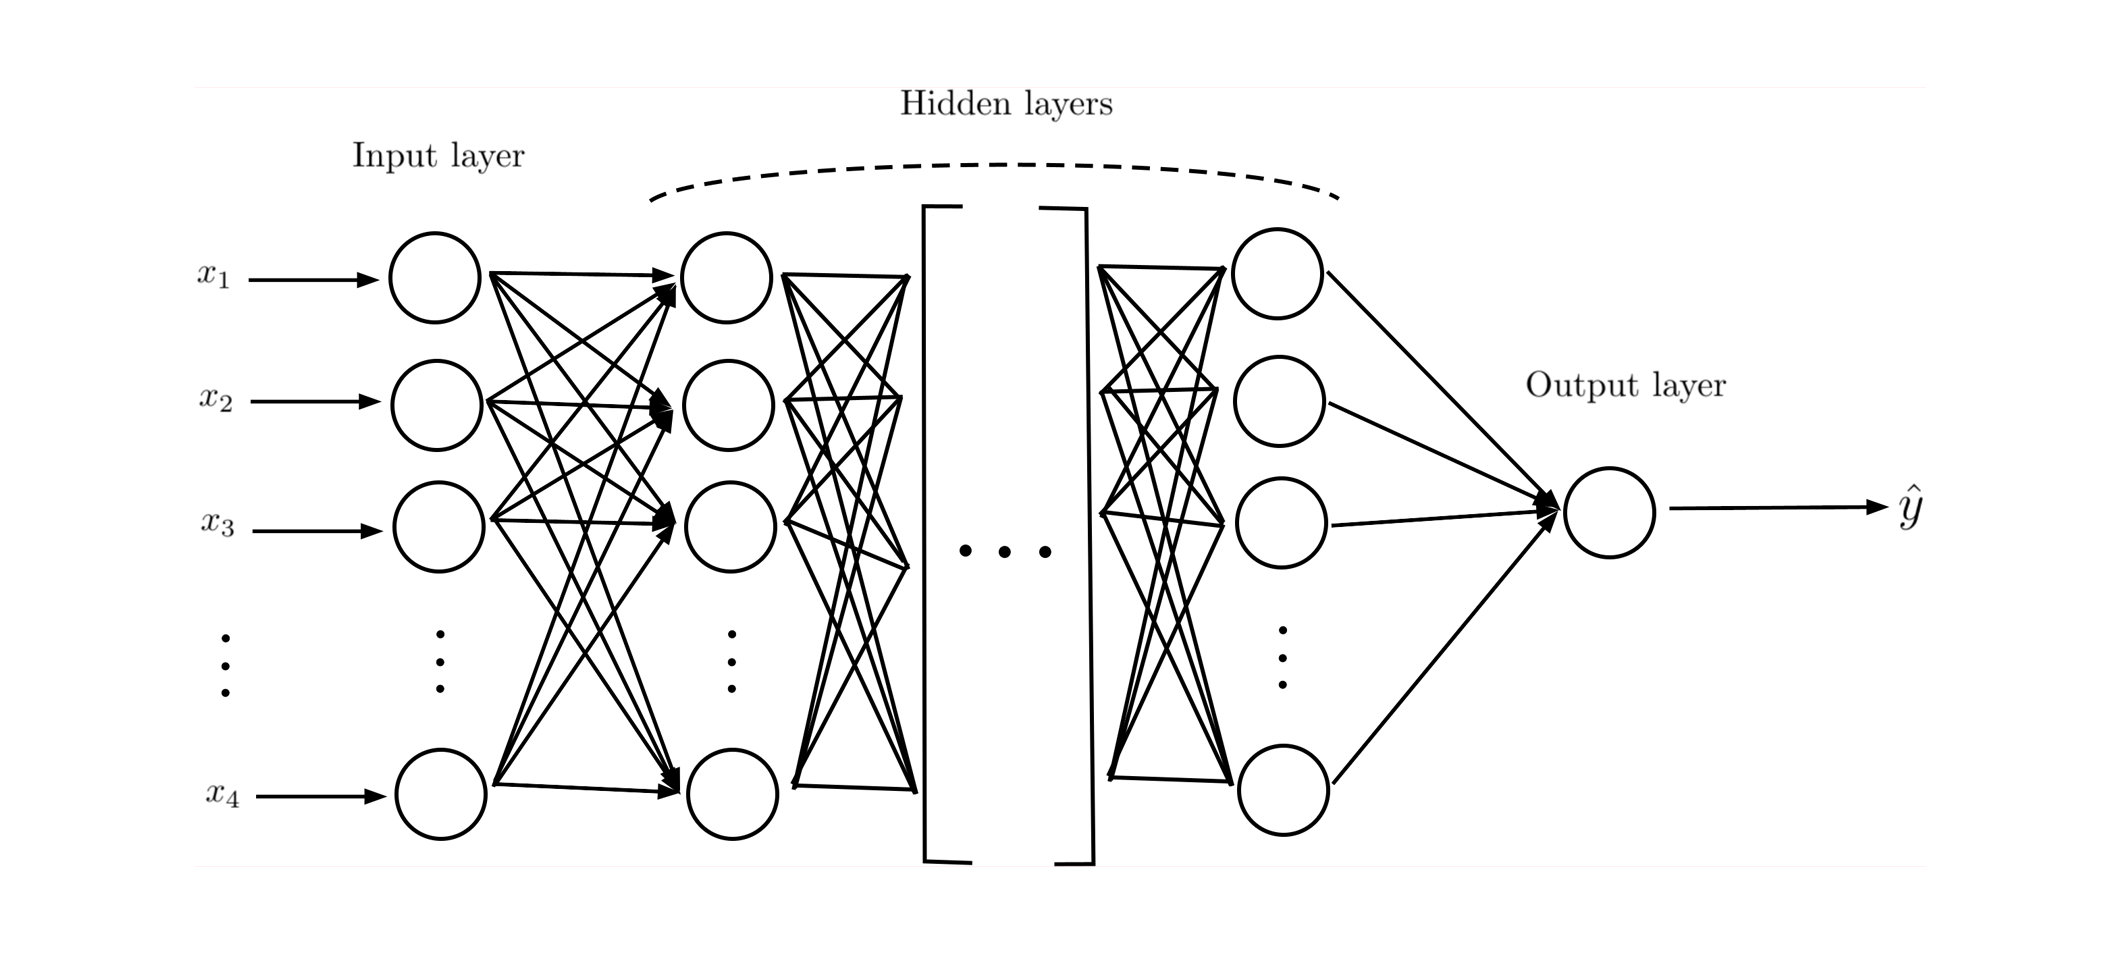

**Informations about the model:**

 - Input: Images of shape 120-by-120 px flatten into an array of shape (m,14400), where m is the number of images.
 - L: Total number of layers including the Input and Output layers.
 - Yhat: Class prediction of the input (0: No Tumor, 1: Tumor) presented in an array of shape (m,1)
 - Weights initialization: Modified He initialization.
 - Activation functions: ReLU for the hidden layers, Sigmoid for the output layer.
 - Optimization algorithm: Gradient descent with L2-regularization.
 - Loss: Cross-Entropy Loss

## Helper functions

**Normalization:**
$$
X_{norm}=\dfrac{X-\bar{X}}{\sqrt{\mbox{Var}(X)}}
$$

In [ ]:
# Normalization function.
# Normalize the input so that its distribution becomes N(0,1).

def normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    data_normalized = (data - mean)/std
    return data_normalized

**Weights initialization:**

$W^{[l]}$ denotes the weights of the layer $l$.

$W_{norm}$ denotes a standard normal initialization of the weights.

$d^{[l]}$ denotes the number of units in the layer $l$.

$$
W^{[l]}_{init} = W_{norm} * \sqrt{\dfrac{2}{d^{[l-1]}+d^{[l]}}}
$$

In [ ]:
# Initialization function.
# Initializing the weights using a modified He initialization to avoid exploding or vanishing gradients.

def initialize_weights_bias(layer_dims):
    L = len(layer_dims)                     
    params = {}
    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/(layer_dims[l-1]+layer_dims[l]))
        params['b' + str(l)] = np.zeros((1, layer_dims[l]))
    return params

**Activation functions:**

**Re**ctified **L**inear **U**nit activation function: $$ \mbox{ReLU}(x) = \max(0,x)$$

Sigmoid activation function: $$ \mbox{Sig}(x)=\dfrac{1}{1+e^{-x}}$$

In [ ]:
# Activation functions.
# Calculate the activation using a ReLU or a Sigmoid function.

def activation(activation_types, Z):
    if (activation_types == 'sigmoid'):
        s = 1/(1+np.exp(-Z))
    else:
        s = np.maximum(np.zeros(Z.shape), Z)  # Z must be np.array
    return s

**Derivative of the activation functions:**

ReLU: 
$$ 
\dfrac{dReLU}{dx}(x)= \begin{cases} 0 & \mbox{if }& x\leq0\\ 1 & \mbox{else}& \end{cases}
$$

Sigmoid:
$$
\mbox{Sig}'(x)=\mbox{Sig(x)}(1-\mbox{Sig(x)})
$$

In [ ]:
# Derivative of the activation functions.

def activation_derivative(activation_types, Z):
    if (activation_types == 'sigmoid'):
        s = np.multiply(activation('sigmoid', Z),(1 - activation('sigmoid', Z)))
    else:
        s = np.maximum(np.zeros(Z.shape), Z)
        s[s!=0] = 1
    return s

**Forward propagation:**

$A$ is the activation of the previous layer. ($A$ is the input for the first layer)

$$\underbrace{Z=A*W^{T}+b\quad =>\quad A=\mbox{Activation}(Z)}_{\mbox{Repeat } L-1 \mbox{ times}}
$$

The last $A$ is the prediction $\hat{y}$.

In [ ]:
# Forward propagation function which calculated a prediction Yhat,
# and save a cache of the linear and non-linear parts for the backprop calculations.

def forward_pass(X, params, layer_dims, activation_types):
    L = len(layer_dims)
    cache={}
    A = X
    cache['A0'] = X
    for l in range(1, L):
        Z = np.dot(A,params['W' + str(l)].T) + params['b' + str(l)]
        A = activation(activation_types[l-1], Z)
        cache['Z' + str(l)] = Z
        cache['A' + str(l)] = A
    return A, cache

**Cross-Entropy Loss:**

$m$ is the number of input images, and $A^{[L]}$ is the activation of the last layer (shaped $(m,1)$).

The L2-regularization term is calculated using the Frobenius norm of the weights, which is given by the following:
$$  \parallel W\parallel_F = \sqrt{\sum_{\substack{1\leq i\leq n \\ 1\leq j \leq m} } |W_{ij}|^2}$$

Cross-Entropy Loss formula:

$$\mathcal{L} = -\frac{1}{m}{(Y^{T}\log(A^{[L]}) + (1 - Y)^{T}\log(1 - A^{[L]}))}+\frac{\lambda}{2m}\sum_{i=1}^L\parallel W^{[i]}\parallel_F$$

In [ ]:
# Loss function.
# Calculates the cross entropy loss between the predicted and true classes.

def cross_entropy_cost(Yhat, Y, params, lamda):
    m = Y.shape[0]
    L = int(len(params)/2)
    L2_reg = 0
    for l in range(1,L+1):
        L2_reg += np.linalg.norm(params['W' + str(l)])**2
    cost = -(1/m)*(np.dot(np.log(Yhat.T),Y)+np.dot(np.log(1-Yhat.T),(1-Y))) + (lamda/(2*m))*L2_reg
    cost = np.squeeze(cost)
    return cost

**Back-propagation:**

The back-propagation function is used to calculate the gradients of the cost function $J$ with respect to $Z$, $W$, $b$, and $A$ for each layer of the network. The calculated gradients are then used to update the weights and biases for each layer.

First, we need to compute the gradient of the loss with respect to the activation of the last layer:
$$ dA^{[L]} = -\dfrac{Y}{A^{[L]}} - \dfrac{1-Y}{1-A^{[L]}}$$
Then we calculate iteratively (going from $l=L$ to $l=1$) the following set of equations which represent the gradients for each layer $l$:

\begin{align*}
 dZ^{[l]} &= dA^{[l]} * g'(Z^{[l]}), \mbox{ (Element wise multiplication)} \\
 dW^{[l]} &= \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} + \frac{\lambda}{m} W^{[l]} \\
 db^{[l]} &= \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)} \\
 dA^{[l-1]} &= \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} 
\end{align*}

The last equation is not calculated for the Input layer.

In [ ]:
def back_prop(Y, Yhat, cache, params, activation_types, lamda):
    grads = {}
    L = int(len(cache)/2)+1
    dYhat = - (np.divide(Y, Yhat) - np.divide(1 - Y, 1 - Yhat))
    m = Y.shape[0]
    for l in reversed(range(1,L)):
        dZ = np.multiply(dYhat, activation_derivative(activation_types[l-1], cache['Z'+str(l)]))
        dW = (1/m)*np.dot(dZ.T, cache['A'+str(l-1)]) + (lamda/m)*params['W' + str(l)]
        db = (1/m)*np.sum(dZ, axis=0, keepdims=True)
        dA_prev = np.dot(dZ, params['W'+str(l)])                 
        dYhat = dA_prev
        grads["dA" + str(l-1)] = dA_prev
        grads["dW" + str(l)] = dW
        grads["db" + str(l)] = db
        assert (dW.shape == params['W'+str(l)].shape)
        assert (db.shape == params['b'+str(l)].shape)
    return grads

**Updating parameters:**

The parameter updating step of the gradient descent algorithm is as follows:
$$ W^{[l]} = W^{[l]} - \alpha dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha db^{[l]}$$

In [ ]:
def update_parameters(parameters, grads, learning_rate, L):
    for l in range(1,L):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
    return parameters

## Model building

Now, it's time to use all of the helper functions defined in the previous section to build the MLP model function.

The model structure is as follow:
 - Input:
     - Training, Validation, and Test data.
     - Model configuration: Learning rate, Regularization parameter $\lambda$, Layers dimension list, Activation types list, Maximum number of iteration.
 - Output:
     - Training and Validation cost history.
     - Parameters of the model (Weights and Biases).
     - Model informations: 
         - Training accuracy
         - Test accuracy
         - Confusion matrix
         - Training duration
         - F1-score
         
The model training process using gradient descent goes as follow:
1. Parameters and intern variables initialization.
2. (Gradient descent) Iterating until convergence or reaching max iteration:
    1. Forward propagation
    2. Loss calculation
    3. Back propagation
    4. Updating parameters
    5. Calculating a convergence estimation.
3. Calculating the test accuracy and the other model informations.

In [ ]:
def model(X_train,X_val,X_test,Y_train,Y_val,Y_test, model_config):
    
    i=0
    conv = 1
    cost_history={
        'Train_loss': [],
        'Val_loss': []
    }
    
    learning_rate = model_config['learning_rate']
    lamda = model_config['lamda']
    layer_dims = model_config['layer_dims']
    activation_types = model_config['activation_types']
    max_iter = model_config['max_iter']
    params = initialize_weights_bias(layer_dims)
    L = len(layer_dims)
    
    toolbar_width = 20
    sys.stdout.write("[%s]" % ("" * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['
    start = time.time()
    
    while (i<max_iter)&(conv>10e-7):
        Yhat, cache = forward_pass(X_train, params, layer_dims, activation_types)
        Yhat_val, _ = forward_pass(X_val, params, layer_dims, activation_types)
        cost_train = cross_entropy_cost(Yhat, Y_train, params, lamda)
        cost_val = cross_entropy_cost(Yhat_val, Y_val, params, lamda)
        
        grads = back_prop(Y_train, Yhat, cache, params, activation_types, lamda)
        params = update_parameters(params, grads, learning_rate, L)
        
        cost_history['Train_loss'].append(cost_train)
        cost_history['Val_loss'].append(cost_val)
        
        if i>2:
            conv = np.abs(cost_history['Train_loss'][-1]-cost_history['Train_loss'][-2])
        i+=1
        if i%100==0:
            sys.stdout.write("=")
            sys.stdout.flush()
    sys.stdout.write("]\n") # this ends the progress bar
    
    end = time.time()
    training_dur = end-start
    train_accuracy = accuracy_score(Y_train, np.round(Yhat))
    
    Yhat_test, _ = forward_pass(X_test, params, layer_dims, activation_types)
    test_accuracy = accuracy_score(Y_test, np.round(Yhat_test))
    conf_matrix = confusion_matrix(Y_test, np.round(Yhat_test), normalize='true')
    
    F1_score = f1_score(Y_test, np.round(Yhat_test))
    
    Model_infos={
        'Train_acc': train_accuracy,
        'Test_acc': test_accuracy,
        'conf_matrix': conf_matrix,
        'Train_dur': training_dur,
        'F1_score': F1_score
    }
    return cost_history, params, Model_infos

## Grid Search

Grid search is a method commonly used to tune the hyper-parameter of a certain model by training a set of models and then picking the best one of them.
In this allpication we're going to use a Random grid search which can be more effective in determining the best set of hyper-parameters.

Hyper-parameters to tune:
 - Learning rate.
 - L2-regularization coefficient.

In [ ]:
def GridSearch(learning_rates, lamdas, model_config):
    best_F1 = 0
    results = {}
    models_cost_history = []
    models_params = []
    Best_model = {}
    m=1
    print('-------------- Beginning of Grid Search --------------')
    print('------------------ Training Models -------------------')
    for i in range(len(learning_rates)):
        for j in range(len(lamdas)):
            model_config['learning_rate'] = learning_rates[i]
            model_config['lamda'] = lamdas[j]
            print('Training of Model '+str(m)+' (Learning rate: '+str(learning_rates[i]) + ' Lambda: ' + str(lamdas[j])+')' )
            cost_history, params, Model_infos = model(X_train_img,X_val_img,X_test_img,Y_train,Y_val,Y_test, model_config)
            print('Training duration: ' + str(Model_infos['Train_dur']/60)  + 'min')
            print('Number of epochs: ' + str(int(len(cost_history['Train_loss']))))
            print('Train accuracy: ' + str(Model_infos['Train_acc']) + ' | ' + 'Test accuracy: ' +
                  str(Model_infos['Test_acc'])+ ' | ' + 'F1 score: ' + str(Model_infos['F1_score']))
            results['Model: '+ str(learning_rates[i]) + ' ' + str(lamdas[j])] = Model_infos
            models_cost_history.append(cost_history)
            if Model_infos['F1_score']>best_F1:
                best_F1 = Model_infos['F1_score']
                Best_model['infos'] = Model_infos
                Best_model['cost_history'] = cost_history
                Best_model['params'] = params  
                Best_model['hyperparams'] = (learning_rates[i],lamdas[j])
            m+=1
            print('')
    print('--------------------- Best Model ---------------------')
    print('Best F1 score: ' + str(Best_model['infos']['F1_score']))
    print('Best hyper-parameters: Learning rate: ' + str(Best_model['hyperparams'][0]) + ' ' +
          'Lambda: '+ str(Best_model['hyperparams'][1]))
    print('----------------- End of Grid Search -----------------')
    return results, models_cost_history, Best_model

# Application

Now, we're going to apply the model we built to the Brain Tumor image dataset. But first, we need to preprocess the data to make it ready for use.

In [ ]:
# Extracting labels

labels = np.array(df.iloc[:,1])

In this preprocessing step we're also scaling the tabular data that we're going to use later on when we train an xgboost model, however we need to prepare both image and tabular data from now so that we can get the same Train/Val/Test split for both models.

In [ ]:
# Normalizing the tabular data (numeric features)

data = df.iloc[:,2:]
Data_normalized = scale(data)

In [ ]:
# Building the master data set using the normalized tabular data

Data_normalized_df = pd.DataFrame(Data_normalized)
images_df = pd.DataFrame(df.iloc[:,0:1])
master_data_df = pd.concat([images_df, Data_normalized_df], axis=1)
master_data_df.head()

In [ ]:
# Splitting the data into Train/Validation/Test sub-sets

np.random.seed(7)
X_train, X_test, Y_train, Y_test = train_test_split(master_data_df, labels, test_size=0.20, random_state=7)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=7)

Y_train = Y_train.reshape(Y_train.shape[0],1)
Y_val = Y_val.reshape(Y_val.shape[0],1)
Y_test = Y_test.reshape(Y_test.shape[0],1)

In [ ]:
# This function is used to seperate the image data from the tabular data for each sub-set, 
# and converts the images into a smaller shape (120-by-120px) using a MaxPooling function.
# The images are then stored in a numpy array.

def image_feat_separator(data):
    images_names_list = list(data.iloc[:,0])
    feat_df = data.iloc[:,1:]
    path_list=[]
    images_list=[]
    for i in images_names_list:
        path = "../input/brain-tumor/Brain Tumor/Brain Tumor/"+i+".jpg"
        path_list.append(path)
    for i in path_list:
        temp = Image.open(i).convert('L')
        array_temp = np.asarray(temp)
        max_pooling_temp = skimage.measure.block_reduce(array_temp, (2,2), np.max)
        flat_temp = list(max_pooling_temp.flatten())
        images_list.append(flat_temp)
        temp.close()
    images_array = np.array(images_list)
    return images_array, feat_df

In [ ]:
X_train_img, X_train_feat = image_feat_separator(X_train)
X_test_img, X_test_feat = image_feat_separator(X_test)
X_val_img, X_val_feat = image_feat_separator(X_val)

In [ ]:
print('The train image set shape:', X_train_img.shape)
print('The test image set shape:', X_test_img.shape)
print('The validation image set shape:', X_val_img.shape)

In [ ]:
# Normalizing the images using the normalize function we built earlier

X_train_img = normalize(X_train_img)
X_test_img = normalize(X_test_img)
X_val_img = normalize(X_val_img)

In [ ]:
# Setting the model configuration

model_config={
    'layer_dims' : [X_train_img.shape[1],8,8,8,4,1],
    'activation_types' : ['ReLu','ReLu','ReLu','ReLu','sigmoid'],
    'max_iter' : 10000
}

**Important notice:**

Don't run the following cell if you don't want to wait for the model to train just use the next cell to load the trained model. The training duration depends on how many hyper-parameters samples you chose, however the training would take about 3 hours using the following configuration.

In [ ]:
# Executing the Grid Search function / Training MLP models
Start_timer = time.time()
learning_rates = list(np.random.uniform(0.0001,0.001,3))
lamdas = list(np.random.uniform(1,2,3))
results, models_cost_history, Best_model = GridSearch(learning_rates, lamdas, model_config)
Stop_timer = time.time()
GridSearch_dur = Stop_timer - Start_timer
print('Grid search training duration: ', GridSearch_dur/60, ' min')

In [ ]:
# Use this only after training to save the trained model !!!

with open('GSresults', 'wb') as f:
    pickle.dump([results, models_cost_history, Best_model], f)

In [ ]:
# Use this if you have a model to load.

#with open('GSresults', 'rb') as f:
#    results, models_cost_history, Best_model = pickle.load(f)

In [ ]:
# Visualizing the learning curves of trained models via grid search.

figure = plt.figure(figsize=(min(len(learning_rates)*4.3,15),min(len(lamdas)*4,15)))
plt.suptitle('Evolution of the Train/Validation Losses for all the trained models',fontsize=15, y=1.05)
nbr_plots = len(learning_rates)*len(lamdas)
alpha_lamda_combinations = [(i,j) for i in learning_rates for j in lamdas]
for i in range(1,nbr_plots+1):
    plt.subplot(len(learning_rates),len(lamdas),i)
    x = list(range(0,len(models_cost_history[i-1]['Train_loss'])))
    y1 = list(np.squeeze( models_cost_history[i-1]['Train_loss']))
    y2 = list(np.squeeze( models_cost_history[i-1]['Val_loss'])) 
    temp_df = pd.DataFrame([x,y1,y2]).T
    temp_df.columns=['x','y1','y2']
    sb.lineplot(data=temp_df, x='x', y='y1')
    sb.lineplot(data=temp_df, x='x', y='y2')
    plt.title('Learning rate:' + str("{:.2e}".format(alpha_lamda_combinations[i-1][0])) + ' Lambda: ' + str("{:.2e}".format(alpha_lamda_combinations[i-1][1])))
    plt.legend(['Train','Validation'])
    plt.xlabel('iteration')
    plt.ylabel('Loss') 
figure.tight_layout(pad=2.0);

In [ ]:
# Function to plot the confusion matrix of the trained model.

def plot_cm(mat,y_ture,ax):
    df_cm = pd.DataFrame(mat, columns=np.unique(y_ture), index = np.unique(y_ture))
    df_cm.index.name = 'True Label'
    df_cm.columns.name = 'Predicted Label'
    sb.heatmap(df_cm, cmap="Blues", cbar=False, annot=True,annot_kws={"size": 10}, ax=ax)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

In [ ]:
# Plotting the learning curve and confusion matrix of the best model.

plt.figure(figsize=(12,5))
plt.suptitle('Best model results', fontsize=14)
ax1 = plt.subplot(1,2,1)
plt.title('Train/Validation Losses evolution')
x = list(range(0,len(Best_model['cost_history']['Train_loss'])))
y1 = list(np.squeeze( Best_model['cost_history']['Train_loss']))
y2 = list(np.squeeze( Best_model['cost_history']['Val_loss'])) 
temp_df = pd.DataFrame([x,y1,y2]).T
temp_df.columns=['x','y1','y2']
sb.lineplot(data=temp_df, x='x', y='y1')
sb.lineplot(data=temp_df, x='x', y='y2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])
ax2 = plt.subplot(1,2,2)
plt.title('Confusion matrix of the test set')
plot_cm(Best_model['infos']['conf_matrix'], Y_test, ax2);

In [ ]:
print('The best grid search model results:')

result_table=[['Train accuracy', Best_model['infos']['Train_acc']],
             ['Test accuracy', Best_model['infos']['Test_acc']],
             ['F1 score', Best_model['infos']['F1_score']],
             ['Training duration', Best_model['infos']['Train_dur']/60]]

display(HTML(tabulate.tabulate(result_table, colalign=("center","center"), tablefmt='html')))

# Xgboost Model

In this final section, we're going to use the Xgboost library to train an Xgboost model using the tabular data.

In [ ]:
# Grid search function for Xgboost models

def xgb_GS(data, nbr_estimators, max_depth, learning_rate):
    X_train_feat = data['X_train_feat']
    X_val_feat = data['X_val_feat']
    X_test_feat = data['X_test_feat']
    Y_train = data['Y_train']
    Y_val = data['Y_val']
    Y_test = data['Y_test']
    best_f1 = 0
    for i in learning_rate:
        for j in max_depth:
            for k in nbr_estimators:
                xgb_model = xgb.XGBClassifier(n_estimators=k, max_depth=j, learning_rate=i)
                xgb_model.fit(X_train_feat, Y_train, verbose=False)
                Yhat_xgb = xgb_model.predict(X_test_feat)
                Yhat_xgb = np.round(Yhat_xgb.reshape(Y_test.shape[0],1))
                score = f1_score(Y_test, Yhat_xgb)
                if score > best_f1:
                    best_f1 = score
                    best_hyper_params=[k,j,i]
    return best_f1, best_hyper_params

In [ ]:
# Variables and Hyper-parameters to feed to the grid seach function.

data={
    'X_train_feat': X_train_feat,
    'X_val_feat': X_val_feat,
    'X_test_feat': X_test_feat,
    'Y_train': Y_train,
    'Y_val': Y_val,
    'Y_test': Y_test
}
nbr_estimators = [5,10,15,20,25]
max_depth = [4,8,16]
learning_rate = [0.1, 0.2, 0.4, 0.6, 0.8]

In [ ]:
best_f1, best_hyper_params = xgb_GS(data, nbr_estimators, max_depth, learning_rate);

In [ ]:
print('The best grid search model results:')

result_table=[['Number of estimators', best_hyper_params[0]],
             ['Max_depth', best_hyper_params[1]],
             ['Learning_rate', best_hyper_params[2]],
             ['F1 score', best_f1]]

display(HTML(tabulate.tabulate(result_table, colalign=("center","center"), tablefmt='html')))

In [ ]:
# Getting the best model using the tuned hyper-parameters. 
start=time.time()
xgb_BM = xgb.XGBClassifier(n_estimators=best_hyper_params[0], max_depth=best_hyper_params[1],
                                     learning_rate=best_hyper_params[2])
eval_set=[(X_train_feat, Y_train), (X_val_feat, Y_val)]
xgb_BM.fit(X_train_feat, Y_train, eval_metric=['logloss','rmse','error'], eval_set=eval_set, verbose=False)
end=time.time()
duration_xgb = end-start
Yhat_xgb_BM = xgb_BM.predict(X_test_feat)
Yhat_xgb_BM = np.round(Yhat_xgb_BM.reshape(Y_test.shape[0],1))

In [ ]:
# retrieve performance metrics
results = xgb_BM.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

In [ ]:
plt.figure(figsize=(12,10))
# plot log loss

plt.subplot(2,1,1)
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Val')
plt.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')

# plot classification rmse
plt.subplot(2,2,3)
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Val')
plt.legend()
plt.ylabel('Classification RMSE')
plt.title('XGBoost Classification RMSE')

# plot classification error
plt.subplot(2,2,4)
plt.plot(x_axis, results['validation_0']['error'], label='Train')
plt.plot(x_axis, results['validation_1']['error'], label='Val')
plt.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error');

In [ ]:
print('The best grid search model results:')

result_table=[['Test accuracy', accuracy_score(Yhat_xgb_BM, Y_test)],
             ['F1 score', f1_score(Yhat_xgb_BM, Y_test)],
             ['Training duration', duration_xgb]]

display(HTML(tabulate.tabulate(result_table, colalign=("center","center"), tablefmt='html')))

In [ ]:
plt.figure(figsize=(6,6))
ax1 = plt.subplot(111)
plt.title('Confusion matrix of the test set')
plot_cm(confusion_matrix(Yhat_xgb_BM, Y_test, normalize='true'), Y_test, ax1);

# Conclusion

The accuracy obtained by the MLP model on the Tumor dataset can be increased by by tuning more hyper parameters or changing the depth of the network. However the best practiec is to use a convolutional neural network (CNN) when teraining a model that takes image data as input. The purpose of this notebook was mainly to implement an MLP model from scratch and see how it performs on an image dataset.

The second part of this notebook was a direct application of the Xgboost model which showed the extremely high performance of this model on a structured dataset.